<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Handwritten Documents

### Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [43]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import editdistance as ed
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Python
import gc
import os
import gzip
import tarfile
import time
import random
import numba as nb

# Data Structures
import pandas as pd
import numpy as np
import json
import csv

# Debug/Progress
from tqdm import tqdm
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Image Manipulations / Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "drive/My Drive/datasets/iam.zip" "/content"
!cp "drive/My Drive/datasets/rimes.zip" "/content"
!unzip -q iam.zip -d iam
!unzip -q rimes.zip -d rimes
!wget -q https://raw.githubusercontent.com/ericburdett/cs601r-dl/master/char_set.json
!rm iam.zip
!rm rimes.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


### Create IAM and RIMES Dataset Classes

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(32, 128), total_imgs=None):
    self.desired_size = desired_size
    self.img_path = '/content/iam/images/'
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['word', 'seg', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    # img = cv2.imread(path + '.png')
    # img = preprocess(path + '.png', (1024, 128, 1))
    img = Image.open(path + '.png')
    img = img.point(lambda p: p > 200 and 255)
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'iam/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index], index

  def __len__(self):
    return len(self.df)


''' RIMES DATSET '''

class RimesDataset(Dataset):
  def __init__(self, desired_size=(32, 128, 1), total_imgs=None):
    self.desired_size = desired_size
    self.img_path = '/content/rimes/images/'
    self.df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path)
    img = img.point(lambda p: p > 200 and 255)
    img = self.resize(img)
    # img = img.astype(np.float32)
    x = transforms.functional.to_tensor(img)

    return x

  def resize(self, img):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = self.desired_size[0] / self.desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = self.desired_size[0]
      new_width = int(self.desired_size[0] // img_ratio)
    else:
      new_height = int(self.desired_size[1] * img_ratio)
      new_width = self.desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = self.desired_size[0] - new_height
    border_right = self.desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def __getitem__(self, index):
    path = 'rimes/images/' + self.df['word'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index], index

  def __len__(self):
    return len(self.df)

0.002504105999832973
Length:  25000
Transcription:  meeting


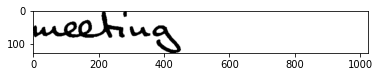

In [61]:
iam = IamDataset(total_imgs=25000, desired_size=(128, 1024, 1))
index = 19

start = time.perf_counter()
img, trans, _ = iam[index]
end = time.perf_counter()
print(end - start)

print('Length: ', len(iam))
print('Transcription: ', trans)
plt.imshow(img.squeeze(), cmap='gray')

0.002024442999754683
Length:  25000
Transcription:  marche


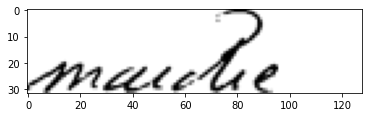

In [46]:
rimes = RimesDataset(total_imgs=25000, desired_size=(32, 128, 1))
index = 1

start = time.perf_counter()
img, trans, _ = rimes[index]
end = time.perf_counter()
print(end - start)

print('Length: ', len(rimes))
print('Transcription: ', trans)
plt.imshow(img.squeeze(), cmap='gray')

### Character Encoding

In [0]:
class Encoder():
  def __init__(self, sequence_size=150):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs, len(string)

  def idxs_to_str(self, idxs):
    string = ''
    idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []
    lengths = []

    for string in batch:
      idx, length = self.str_to_idxs(string)
      idxs.append(idx)
      if length > self.sequence_size:
        length = self.sequence_size
      lengths.append(length)
    
    return idxs, lengths
  
  def idxs_to_str_batch(self, batch):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs))
    
    return strings

### Helper Functions

In [0]:
def show_imgs(x, new_fig=True):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure() # figsize=(50,100)
    plt.imshow(grid.numpy())

def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

def err(prediction, target):
  dist = ed.eval(target, prediction)
  if len(target) == 0:
    return len(prediction)
  
  return float(dist) / float(len(target))

def cer(prediction, target):
  prediction = ' '.join(prediction.split())
  target = ' '.join(target.split())

  return err(prediction, target)

def wer(prediction, target):
  prediction = prediction.split()
  target = target.split()

  return err(prediction, target)

def cer_batch(predictions, targets):
  cers = []

  for prediction, target in zip(predictions, targets):
    cers.append(cer(prediction, target))
  
  return np.mean(cers)

def wer_batch(predictions, targets):
  wers = []

  for prediction, target in zip(predictions, targets):
    wers.append(wer(prediction, target))

  return np.mean(wers)

### Model

In [0]:
class Recognizer(nn.Module):
  def __init__(self, sequence_size=20):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1
    self.sequence_size = sequence_size

    # Encoder
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.tanh1 = nn.Tanh()
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) # 4x2
    self.tanh2 = nn.Tanh()
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tanh3 = nn.Tanh()
    self.conv4 = nn.Conv2d(32, 64, 3, 1, 1) # 4x2
    self.tanh4 = nn.Tanh()
    self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
    self.tanh5 = nn.Tanh()

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, self.sequence_size)
    self.softmax = nn.LogSoftmax(dim=1)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.tanh1(out)
    out = self.conv2(out)
    out = self.tanh2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)
    out = self.tanh3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)
    out = self.tanh4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)
    out = self.tanh5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [0]:
class ReverseLayerF(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, alpha):
    ctx.alpha = alpha
    return x.view_as(x)
  
  @staticmethod
  def backward(ctx, grad_output):
    output = grad_output.neg() * ctx.alpha
    return output, None

In [0]:
class DannRecognizer(nn.Module):
  def __init__(self, sequence_size=20):
    super(DannRecognizer, self).__init__()
    
    self.hidden_size = 256
    self.num_layers = 1
    self.sequence_size = sequence_size

    # Feature Extractor
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Tanh())
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.Tanh())
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.Tanh())
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.Tanh())
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.Tanh())    
    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())
    self.mp = nn.MaxPool2d((32, 1))

    # Label Classifier
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, self.sequence_size)
    self.softmax = nn.LogSoftmax(dim=1)

    # Domain Classifier
    self.fc3 = nn.Sequential(nn.Linear(128 * 128, 128), nn.BatchNorm1d(128), nn.ReLU())
    self.fc4 = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

  def forward(self, x, alpha=0.05):
    # Feature Extractor
    feat = self.conv1(x)

    feat = self.conv2(feat)
    gate = self.gate1(feat)
    feat = feat * gate

    feat = self.conv3(feat)
    gate = self.gate2(feat)
    feat = feat * gate

    feat = self.conv4(feat)
    gate = self.gate3(feat)
    feat = feat * gate

    feat = self.conv5(feat)
    feat = self.mp(feat)
    feat = feat.view(-1, 128, 128)

    # Label Classifier
    label, _ = self.gru1(feat)
    label = self.fc1(label)
    label, _ = self.gru2(label)
    label = self.fc2(label)
    label = self.softmax(label)
    label = label.permute(2, 0, 1)

    # Domain Classifier
    domain = ReverseLayerF.apply(feat, alpha)
    domain = domain.view(-1, 128 * 128)
    domain = self.fc3(domain)
    domain = self.fc4(domain)
    domain = domain.squeeze()

    return label, domain

In [67]:
rec = DannRecognizer()
print(parameter_count(rec))
label, domain = rec(torch.randn(10, 1, 32, 128))
print('label: ', label.shape)
print('domain: ', domain.shape)
print(domain)

3506117
label:  torch.Size([20, 10, 128])
domain:  torch.Size([10])
tensor([0.4578, 0.4712, 0.5078, 0.5078, 0.4716, 0.5036, 0.5717, 0.5124, 0.4990,
        0.4974], grad_fn=<SqueezeBackward0>)


# Domain Adversarial Transfer

## IAM/Rimes Training Loop

In [0]:
def dann_train(source_train_dataset, source_val_dataset, target_dataset):
  try:
    EPOCHS = 100
    BATCH_SIZE = 200
    ITERATION_SAMPLE = 3000
    SEQUENCE_SIZE = 20
    DMN_RATIO = 5

    source_train_loader = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    source_val_loader = DataLoader(source_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)
    recognizer = DannRecognizer(sequence_size=SEQUENCE_SIZE).cuda()
    
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3, weight_decay=1e-4)
    hwr_objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)
    dmn_objective = nn.BCELoss()

    train_src_dmn_loss_epochs, train_tgt_dmn_loss_epochs, train_hwr_loss_epochs, train_cer_epochs, train_wer_epochs = [], [], [], [], []
    src_val_hwr_loss_epochs, src_val_cer_epochs, src_val_wer_epochs = [], [], []
    tgt_hwr_loss_epochs, tgt_cer_epochs, tgt_wer_epochs = [], [], []
    
    for epoch in range(EPOCHS):

      train_src_dmn_losses, train_tgt_dmn_losses, train_hwr_losses, train_cers, train_wers = [], [], [], [], []
      src_val_hwr_losses, src_val_cers, src_val_wers = [], [], []
      tgt_hwr_losses, tgt_cers, tgt_wers = [], [], []

      # Source & Target Training Loop
      recognizer.train()
      train_loop = tqdm(total=len(source_train_loader), position=0, leave=True)
      for batch_num, ((source_imgs, source_words), (target_imgs, target_words)) in enumerate(zip(source_train_loader, target_loader)):
        batch_size = source_imgs.shape[0]
        p = float(batch_num + epoch * len(source_train_loader)) / EPOCHS / len(source_train_loader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Train with source imgs
        source_idxs, source_word_lengths = encoder.str_to_idxs_batch(source_words)
        source_imgs, hwr_labels = source_imgs.cuda(), torch.tensor(source_idxs).cuda()
        hwr_input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        hwr_target_lengths = torch.tensor(source_word_lengths).cuda()
        src_dmn_labels = torch.ones(batch_size).cuda()

        hwr_preds, src_dmn_preds = recognizer(source_imgs, alpha)

        hwr_loss = hwr_objective(hwr_preds, hwr_labels, hwr_input_lengths, hwr_target_lengths)
        hwr_loss = torch.mean(hwr_loss)
        src_dmn_loss = dmn_objective(src_dmn_preds, src_dmn_labels)

        preds_strings = encoder.idxs_to_str_batch(hwr_preds.permute(1, 0, 2).argmax(dim=2).cpu())
        preds_cer = cer_batch(preds_strings, source_words)
        preds_wer = wer_batch(preds_strings, source_words)

        # Train with target imgs
        target_imgs = target_imgs.cuda()
        tgt_dmn_labels = torch.zeros(batch_size).cuda()

        _, tgt_dmn_preds = recognizer(target_imgs, alpha)

        tgt_dmn_loss = dmn_objective(tgt_dmn_preds, tgt_dmn_labels)

        # Keep track of our progress
        train_src_dmn_losses.append(src_dmn_loss.item())
        train_tgt_dmn_losses.append(tgt_dmn_loss.item())
        train_hwr_losses.append(hwr_loss.item())
        train_cers.append(preds_cer)
        train_wers.append(preds_wer)

        train_loop.set_description('Train - Epoch: {}, HWR Loss: {:.4f}, SrcDmn Loss: {:.4f}, TgtDmn Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgHWR Loss: {:.4f}, AvgSrcDmn Loss: {:.4f}, AvgTgtDmn Loss: {:.4f} AvgCER: {:.4f} AvgWER: {:.4f}'.format(
            epoch, hwr_loss.item(), src_dmn_loss.item(), tgt_dmn_loss.item(), preds_cer, preds_wer, np.mean(train_hwr_losses), np.mean(train_src_dmn_losses), np.mean(train_tgt_dmn_losses), np.mean(train_cers), np.mean(train_wers)
        ))
        train_loop.update(1)

        loss = hwr_loss + (src_dmn_loss + tgt_dmn_loss) * DMN_RATIO

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      train_loop.close()
      gc.collect()

      # Source Validation Loop
      recognizer.eval()
      val_loop = tqdm(total=len(source_val_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(source_val_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()
          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds, _ = recognizer(imgs)

          loss = hwr_objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          src_val_hwr_losses.append(loss.item())
          src_val_cers.append(preds_cer)
          src_val_wers.append(preds_wer)

          val_loop.set_description('Val   - Epoch: {}, HWR Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgHWR Loss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(src_val_hwr_losses), np.mean(src_val_cers), np.mean(src_val_wers)
          ))
          val_loop.update(1)

      val_loop.close()
      gc.collect()

      # Target Test Loop
      test_loop = tqdm(total=len(target_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(target_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()
          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds, _ = recognizer(source_imgs)

          loss = hwr_objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          tgt_hwr_losses.append(loss.item())
          tgt_cers.append(preds_cer)
          tgt_wers.append(preds_wer)

          test_loop.set_description('Test  - Epoch: {}, HWR Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgHWR Loss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(tgt_hwr_losses), np.mean(tgt_cers), np.mean(tgt_wers)
          ))
          test_loop.update(1)
      
      test_loop.close()
      gc.collect()
      
      # Keep track of our progress

      # Train Loop
      train_src_dmn_loss_epochs.append(np.mean(train_src_dmn_losses))
      train_tgt_dmn_loss_epochs.append(np.mean(train_tgt_dmn_losses))
      train_hwr_loss_epochs.append(np.mean(train_hwr_losses))
      train_cer_epochs.append(np.mean(train_cers))
      train_wer_epochs.append(np.mean(train_wers))

      # Validation Loop
      src_val_hwr_loss_epochs.append(np.mean(src_val_hwr_losses))
      src_val_cer_epochs.append(np.mean(src_val_cers))
      src_val_wer_epochs.append(np.mean(src_val_wers))

      # Test Loop
      tgt_hwr_loss_epochs.append(np.mean(tgt_hwr_losses))
      tgt_cer_epochs.append(np.mean(tgt_cers))
      tgt_wer_epochs.append(np.mean(tgt_wers))

  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, (train_src_dmn_loss_epochs, train_tgt_dmn_loss_epochs), (train_hwr_loss_epochs, src_val_hwr_loss_epochs, tgt_hwr_loss_epochs), (train_cer_epochs, src_val_cer_epochs, tgt_cer_epochs), (train_wer_epochs, src_val_wer_epochs, tgt_wer_epochs)

## IAM to Rimes

### Training Loop

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=40000)
rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)
iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [30000, 10000])

dann_recognizer, dann_domain_losses, dann_label_losses, dann_cer, dann_wer = dann_train(iam_train_dataset, iam_val_dataset, rimes_dataset)

Train - Epoch: 0, HWR Loss: 16.1337, SrcDmn Loss: 0.5045, TgtDmn Loss: 0.4863, CER: 1.0000, WER: 1.0000, AvgHWR Loss: 22.2997, AvgSrcDmn Loss: 0.6052, AvgTgtDmn Loss: 0.5899 AvgCER: 1.0277 AvgWER: 1.0048: 100%|██████████| 150/150 [01:48<00:00,  1.38it/s]
Val   - Epoch: 0, HWR Loss: 15.1207, CER: 1.0000, WER: 1.0000, AvgHWR Loss: 16.3163, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 50/50 [00:10<00:00,  4.60it/s]
Test  - Epoch: 0, HWR Loss: 20.4378, CER: 1.0000, WER: 1.0000, AvgHWR Loss: 19.9729, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 150/150 [00:31<00:00,  4.77it/s]
Train - Epoch: 1, HWR Loss: 16.5661, SrcDmn Loss: 0.5747, TgtDmn Loss: 0.4725, CER: 1.0000, WER: 1.0000, AvgHWR Loss: 16.0949, AvgSrcDmn Loss: 0.4774, AvgTgtDmn Loss: 0.4699 AvgCER: 1.0000 AvgWER: 1.0000: 100%|██████████| 150/150 [01:47<00:00,  1.39it/s]
Val   - Epoch: 1, HWR Loss: 15.7459, CER: 1.0000, WER: 1.0000, AvgHWR Loss: 15.9986, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 50/50 [00:11<00:00,  4.5

### Results

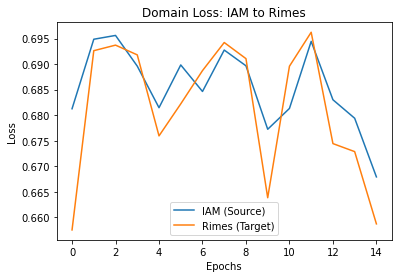

IAM: [0.6812588717540106, 0.6948735131820043, 0.6956189384063085, 0.6896080535650253, 0.6814657964309057, 0.6898403978347778, 0.6846431831518809, 0.6927541963259379, 0.689670954545339, 0.6772417761882146, 0.6813171176115672, 0.6944561463594436, 0.6830206082264583, 0.67940034588178, 0.6679125545422236]
Rimes: [0.6575283694267273, 0.6926314785083135, 0.6937210426727931, 0.6918110179901124, 0.6759459702173869, 0.6822140224774679, 0.6887286420663198, 0.6942315965890884, 0.691074546178182, 0.6638310521841049, 0.6895877805352211, 0.696243624885877, 0.6744347240527471, 0.6728643916050593, 0.6587101115783056]


In [0]:
plt.title('Domain Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(dann_domain_losses[0], label='IAM (Source)')
plt.plot(dann_domain_losses[1], label='Rimes (Target)')
plt.legend()
plt.show()
print('IAM:', dann_domain_losses[0])
print('Rimes:', dann_domain_losses[1])

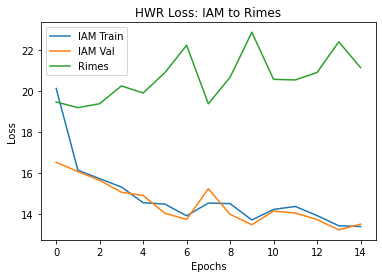

Train: [20.108432022730508, 16.124411783218385, 15.714550552368165, 15.30674134572347, 14.543769645690919, 14.473915452957153, 13.90470723470052, 14.524476779301962, 14.497991307576497, 13.70093386967977, 14.214474617640178, 14.359836298624675, 13.916099096934001, 13.418025471369425, 13.383097190856933]
Val: [16.512666759490966, 16.058329429626465, 15.635044660568237, 15.055041055679322, 14.895471267700195, 14.02670316696167, 13.72982084274292, 15.222582139968871, 13.97691065788269, 13.468798332214355, 14.136074352264405, 14.038685302734375, 13.720411338806151, 13.2162047290802, 13.49653221130371]
Test: [19.451131534576415, 19.175159759521485, 19.36680362065633, 20.234496313730876, 19.88995345433553, 20.879960460662844, 22.215912647247315, 19.364086561203003, 20.65606004714966, 22.849962933858237, 20.554918270111084, 20.525620956420898, 20.889597047170003, 22.38298678080241, 21.127969881693524]


In [0]:
plt.title('HWR Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(dann_label_losses[0], label='IAM Train')
plt.plot(dann_label_losses[1], label='IAM Val')
plt.plot(dann_label_losses[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', dann_label_losses[0])
print('Val:', dann_label_losses[1])
print('Test:', dann_label_losses[2])

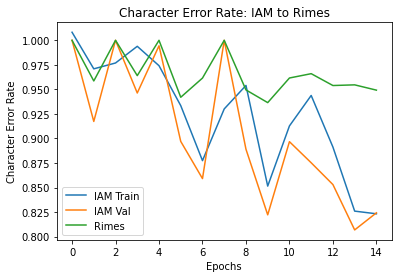

Train: [1.0082061892736893, 0.9709167720106688, 0.976877131003528, 0.9938800235909601, 0.974126343409629, 0.9334345347776578, 0.8773942621147341, 0.930086638199119, 0.9539885594090005, 0.8514451290528071, 0.9127578547944144, 0.9437893228769852, 0.8911949472526097, 0.8259479688796756, 0.823226513530902]
Val: [1.0, 0.9173128249528248, 1.0, 0.9463022775835276, 0.9944000000000002, 0.8969753909978911, 0.8590916641691642, 1.0, 0.8890155192030192, 0.8221772963147965, 0.8967011555111556, 0.8752140856365856, 0.8529974092574095, 0.806799327894328, 0.8242158520646021]
Test: [1.0, 0.9585691084140892, 1.0, 0.9640049242921109, 1.0, 0.9419729750873481, 0.9615152732180673, 1.0, 0.9494391998313862, 0.936497489970613, 0.9615875852885218, 0.9659914573559968, 0.9539176708340679, 0.9546042080020369, 0.9492170379654745]


In [0]:
plt.title('Character Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(dann_cer[0], label='IAM Train')
plt.plot(dann_cer[1], label='IAM Val')
plt.plot(dann_cer[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', dann_cer[0])
print('Val:', dann_cer[1])
print('Test:', dann_cer[2])

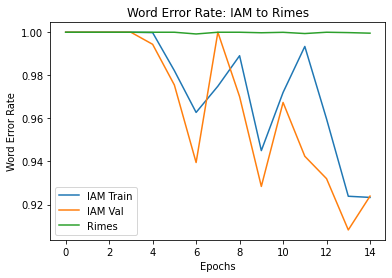

Train: [1.0, 1.0, 1.0, 1.0, 0.9998333333333332, 0.9821666666666666, 0.9627666666666668, 0.9749333333333334, 0.9891000000000001, 0.9450333333333333, 0.9720333333333334, 0.9934, 0.9597333333333334, 0.9238333333333333, 0.9233]
Val: [1.0, 1.0, 1.0, 1.0, 0.9944000000000002, 0.9754999999999999, 0.9395000000000002, 1.0, 0.9701000000000001, 0.9283999999999999, 0.9673999999999998, 0.9424000000000001, 0.932, 0.9082000000000001, 0.9239]
Test: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9992, 1.0, 1.0, 0.9997666666666669, 0.9999666666666667, 0.9994, 1.0, 0.9998333333333335, 0.9995666666666667]


In [0]:
plt.title('Word Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(dann_wer[0], label='IAM Train')
plt.plot(dann_wer[1], label='IAM Val')
plt.plot(dann_wer[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', dann_wer[0])
print('Val:', dann_wer[1])
print('Test:', dann_wer[2])

# Baseline Transfer

### IAM/Rimes Training

In [0]:
def train(train_dataset, val_dataset, test_dataset):
  try:
    EPOCHS = 100
    BATCH_SIZE = 250
    ITERATION_SAMPLE = 3000
    SEQUENCE_SIZE = 20

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)
    recognizer = Recognizer(sequence_size=SEQUENCE_SIZE).cuda()
    
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3)

    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    train_losses_epochs = []
    val_losses_epochs = []
    test_losses_epochs = []

    train_cer_epochs = []
    val_cer_epochs = []
    test_cer_epochs = []

    train_wer_epochs = []
    val_wer_epochs = []
    test_wer_epochs = []

    for epoch in range(EPOCHS):
      train_losses = []
      val_losses = []
      test_losses = []

      train_cers = []
      val_cers = []
      test_cers = []

      train_wers = []
      val_wers = []
      test_wers = []

      # Training Loop
      recognizer = recognizer.train()
      train_loop = tqdm(total=len(train_loader), position=0, leave=True)
      for batch_num, (imgs, words, _) in enumerate(train_loader):
        batch_size = imgs.shape[0]

        idxs, word_lengths = encoder.str_to_idxs_batch(words)

        imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

        input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        target_lengths = torch.tensor(word_lengths).cuda()

        preds = recognizer(imgs)

        loss = objective(preds, labels, input_lengths, target_lengths)
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
        preds_cer = cer_batch(preds_strings, words)
        preds_wer = wer_batch(preds_strings, words)

        train_losses.append(loss.item())
        train_cers.append(preds_cer)
        train_wers.append(preds_wer)

        train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
            epoch, loss.item(), preds_cer, preds_wer, np.mean(train_losses), np.mean(train_cers), np.mean(train_wers)))
        train_loop.update(1)
      
      train_loop.close()

      # Validation Loop
      recognizer = recognizer.eval()
      val_loop = tqdm(total=len(val_loader), position=0, leave=True)
      for batch_num, (imgs, words, _) in enumerate(val_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)

          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          optimizer.zero_grad()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          val_losses.append(loss.item())
          val_cers.append(preds_cer)
          val_wers.append(preds_wer)

          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(val_losses), np.mean(val_cers), np.mean(val_wers)))
          val_loop.update(1)

      val_loop.close()

      # Test Loop
      recognizer = recognizer.eval()
      test_loop = tqdm(total=len(test_loader), position=0, leave=True)
      for batch_num, (imgs, words, _) in enumerate(test_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)

          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          optimizer.zero_grad()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)

          preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2).cpu())
          preds_cer = cer_batch(preds_strings, words)
          preds_wer = wer_batch(preds_strings, words)

          test_losses.append(loss.item())
          test_cers.append(preds_cer)
          test_wers.append(preds_wer)

          test_loop.set_description('Test  - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, loss.item(), preds_cer, preds_wer, np.mean(test_losses), np.mean(test_cers), np.mean(test_wers)))
          test_loop.update(1)

      test_loop.close()

      train_losses_epochs.append(np.mean(train_losses))
      val_losses_epochs.append(np.mean(val_losses))
      test_losses_epochs.append(np.mean(test_losses))

      train_cer_epochs.append(np.mean(train_cers))
      val_cer_epochs.append(np.mean(val_cers))
      test_cer_epochs.append(np.mean(test_cers))

      train_wer_epochs.append(np.mean(train_wers))
      val_wer_epochs.append(np.mean(val_wers))
      test_wer_epochs.append(np.mean(test_wers))
  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, (train_losses_epochs, val_losses_epochs, test_losses_epochs), (train_cer_epochs, val_cer_epochs, test_cer_epochs), (train_wer_epochs, val_wer_epochs, test_wer_epochs) 

## Train on the IAM Dataset, Test on the Rimes Dataset

### Training Loop

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)

iam_train_size = int(.8 * len(iam_dataset))
iam_val_size = len(iam_dataset) - iam_train_size

iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [iam_train_size, iam_val_size])

rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)
iam_to_rimes_recognizer, iam_to_rimes_losses, iam_to_rimes_cers, iam_to_rimes_wers = train(iam_train_dataset, iam_val_dataset, rimes_dataset)

Train - Epoch: 0, Loss: 17.0957, CER: 1.0000, WER: 1.0000, AvgLoss: 25.8822, AvgCER: 1.0265, AvgWER: 1.0000: 100%|██████████| 96/96 [00:32<00:00,  2.99it/s]
Val   - Epoch: 0, Loss: 18.4080, CER: 1.0000, WER: 1.0000, AvgLoss: 17.6277, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.10it/s]
Test  - Epoch: 0, Loss: 21.8537, CER: 1.0000, WER: 1.0000, AvgLoss: 20.2709, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:25<00:00,  4.67it/s]
Train - Epoch: 1, Loss: 15.9648, CER: 1.0000, WER: 1.0000, AvgLoss: 16.9077, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 96/96 [00:32<00:00,  3.00it/s]
Val   - Epoch: 1, Loss: 16.1728, CER: 1.0000, WER: 1.0000, AvgLoss: 16.4571, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.16it/s]
Test  - Epoch: 1, Loss: 20.1087, CER: 1.0000, WER: 1.0000, AvgLoss: 19.7243, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:25<00:00,  4.71it/s]
Train - Epoch: 2, Loss: 16.8037, CER: 1.0000, WER: 1.0

### Results

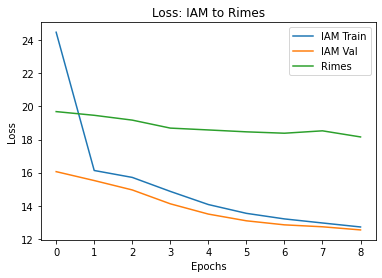

Train: [24.48729008436203, 16.127482573191326, 15.709280560413996, 14.863898466030756, 14.068698853254318, 13.536660929520925, 13.19942045211792, 12.953817009925842, 12.712600161631903]
Val: [16.05826711654663, 15.519538561503092, 14.951684832572937, 14.113074978192648, 13.491466204325357, 13.085466623306274, 12.840948025385538, 12.723644614219666, 12.534332752227783]
Test: [19.68876709938049, 19.464837821324668, 19.173483657836915, 18.690806245803834, 18.579396613438924, 18.464976596832276, 18.381416670481364, 18.526065254211424, 18.15645627975464]


In [0]:
plt.title('Loss: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(iam_to_rimes_losses[0], label='IAM Train')
plt.plot(iam_to_rimes_losses[1], label='IAM Val')
plt.plot(iam_to_rimes_losses[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_losses[0])
print('Val:', iam_to_rimes_losses[1])
print('Test:', iam_to_rimes_losses[2])

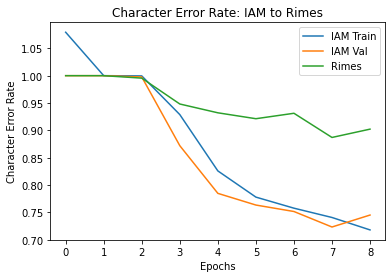

Train: [1.0794071034697872, 1.0, 0.9995792639073889, 0.9288273538382912, 0.8258470322034418, 0.7779493191568995, 0.7577146766538988, 0.7406994753621349, 0.7179652652478454]
Val: [1.0, 1.0, 0.9976925287675288, 0.8719763150520503, 0.7848157826922533, 0.7634400736790443, 0.7516309471574177, 0.7232875148952355, 0.7451596459368518]
Test: [1.0, 1.0, 0.9954906817583288, 0.9482004572041879, 0.9321050213954434, 0.9213034824782774, 0.9312469451131371, 0.8870387122519436, 0.9022343494061837]


In [0]:
plt.title('Character Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(iam_to_rimes_cers[0], label='IAM Train')
plt.plot(iam_to_rimes_cers[1], label='IAM Val')
plt.plot(iam_to_rimes_cers[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_cers[0])
print('Val:', iam_to_rimes_cers[1])
print('Test:', iam_to_rimes_cers[2])

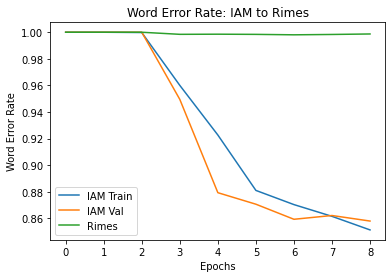

Train: [1.0, 1.0, 0.9997916666666667, 0.9600416666666666, 0.9227083333333335, 0.8810416666666668, 0.8703750000000001, 0.8615416666666667, 0.8513333333333334]
Val: [1.0, 1.0, 1.0, 0.9494999999999999, 0.8793333333333333, 0.8706666666666667, 0.8593333333333334, 0.8621666666666666, 0.858]
Test: [1.0, 1.0, 1.0, 0.9984333333333334, 0.9985333333333334, 0.9984, 0.9980666666666667, 0.9983333333333334, 0.9987000000000001]


In [0]:
plt.title('Word Error Rate: IAM to Rimes')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(iam_to_rimes_wers[0], label='IAM Train')
plt.plot(iam_to_rimes_wers[1], label='IAM Val')
plt.plot(iam_to_rimes_wers[2], label='Rimes')
plt.legend()
plt.show()
print('Train:', iam_to_rimes_wers[0])
print('Val:', iam_to_rimes_wers[1])
print('Test:', iam_to_rimes_wers[2])

## Train on the Rimes Dataset, Test on the Iam Dataset

### Train Loop

In [0]:
rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)

rimes_train_size = int(.8 * len(rimes_dataset))
rimes_val_size = len(rimes_dataset) - rimes_train_size

rimes_train_dataset, rimes_val_dataset = torch.utils.data.random_split(rimes_dataset, [rimes_train_size, rimes_val_size])

iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)

rimes_to_iam_recognizer, rimes_to_iam_losses, rimes_to_iam_cers, rimes_to_iam_wers = train(rimes_train_dataset, rimes_val_dataset, iam_dataset)

Train - Epoch: 0, Loss: 16.8285, CER: 1.0000, WER: 1.0000, AvgLoss: 30.4208, AvgCER: 1.2084, AvgWER: 1.0107: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]
Val   - Epoch: 0, Loss: 18.8274, CER: 1.0000, WER: 1.0000, AvgLoss: 18.1716, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]
Test  - Epoch: 0, Loss: 18.2049, CER: 1.0000, WER: 1.0000, AvgLoss: 17.8603, AvgCER: 1.0000, AvgWER: 1.0000: 100%|██████████| 120/120 [00:24<00:00,  4.90it/s]
Train - Epoch: 1, Loss: 16.6592, CER: 0.9298, WER: 1.0000, AvgLoss: 17.3892, AvgCER: 0.9781, AvgWER: 1.0000: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]
Val   - Epoch: 1, Loss: 15.9383, CER: 1.0000, WER: 1.0000, AvgLoss: 17.0093, AvgCER: 0.9999, AvgWER: 1.0000: 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]
Test  - Epoch: 1, Loss: 16.9962, CER: 0.9990, WER: 1.0000, AvgLoss: 18.1094, AvgCER: 0.9993, AvgWER: 1.0000: 100%|██████████| 120/120 [00:24<00:00,  4.87it/s]
Train - Epoch: 2, Loss: 17.8804, CER: 1.0000, WER: 1.0

### Results

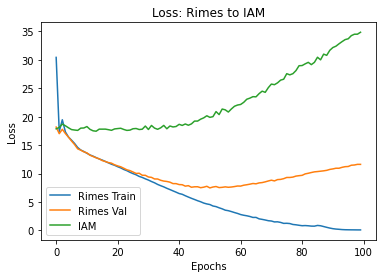

Train: [30.420798937479656, 17.389217754205067, 19.459588527679443, 17.327002217372257, 16.423241247733433, 15.874862680832544, 15.28619239727656, 14.580526570479075, 14.137240966161093, 13.881320168574652, 13.565908869107565, 13.270052015781403, 13.058069626490274, 12.808153480291367, 12.563635498285294, 12.370587488015493, 12.128782361745834, 11.87898787856102, 11.641114691893259, 11.452481577793757, 11.204694559176763, 10.989793638388315, 10.715489765008291, 10.505810489257177, 10.22585109869639, 9.98928133646647, 9.78399113814036, 9.49799088637034, 9.318909168243408, 9.073429842789968, 8.860515197118124, 8.600726306438446, 8.37596740325292, 8.08879184226195, 7.865925704439481, 7.658558666706085, 7.408094048500061, 7.1868923256794615, 6.955196291208267, 6.728188460071881, 6.487294976909955, 6.355518847703934, 6.101044113437335, 5.870999013384183, 5.648304685950279, 5.442437767982483, 5.227690880497296, 5.042979396879673, 4.811105820039908, 4.661197021603584, 4.553656950592995, 4.297

In [0]:
plt.title('Loss: Rimes to IAM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(rimes_to_iam_losses[0], label='Rimes Train')
plt.plot(rimes_to_iam_losses[1], label='Rimes Val')
plt.plot(rimes_to_iam_losses[2], label='IAM')
plt.legend()
plt.show()
print('Train:', rimes_to_iam_losses[0])
print('Val:', rimes_to_iam_losses[1])
print('Test:', rimes_to_iam_losses[2])

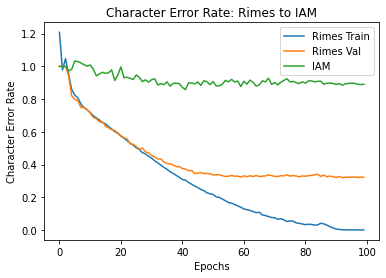

Train: [1.208376519123578, 0.9780860597735598, 1.0472813647001147, 0.9509903014809264, 0.857780333497521, 0.8246861216908092, 0.8078997022143163, 0.769536981700217, 0.7480044879446535, 0.7350660298647432, 0.7187707642167201, 0.6990905938662372, 0.6858380210509806, 0.6725579779867462, 0.6563778359406117, 0.6482202332253802, 0.6322301230972186, 0.6174250090391634, 0.6013956329175998, 0.5903625855421811, 0.5741550935209943, 0.5617867919219941, 0.5453909767350025, 0.5309708859937721, 0.518231209252349, 0.502615570326324, 0.49160525054330195, 0.47279177168487835, 0.46458739687599976, 0.4500225449625266, 0.4391884593313821, 0.42257819745273784, 0.4098722731686886, 0.39708618658710576, 0.38261839313668355, 0.37109343491815916, 0.35679402196387483, 0.3457445296159451, 0.3340934204582182, 0.321969394409376, 0.30872886096746394, 0.3046925277575094, 0.29089292529366056, 0.2801421002336444, 0.2690396536061977, 0.2589703405356898, 0.24807465265195042, 0.24034098457370515, 0.2276236268497298, 0.2211

In [0]:
plt.title('Character Error Rate: Rimes to IAM')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(rimes_to_iam_cers[0], label='Rimes Train')
plt.plot(rimes_to_iam_cers[1], label='Rimes Val')
plt.plot(rimes_to_iam_cers[2], label='IAM')
plt.legend()
plt.show()
print('Train:', rimes_to_iam_cers[0])
print('Val:', rimes_to_iam_cers[1])
print('Test:', rimes_to_iam_cers[2])

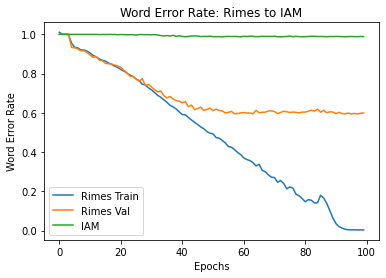

Train: [1.0107083333333333, 1.0, 1.0006666666666666, 0.9978333333333333, 0.9550833333333334, 0.933875, 0.9311250000000001, 0.9204583333333334, 0.9200416666666668, 0.9149583333333334, 0.9056250000000002, 0.8925000000000001, 0.8852500000000001, 0.87475, 0.8682500000000001, 0.8636666666666667, 0.8543750000000001, 0.8466250000000001, 0.8380000000000001, 0.8310416666666667, 0.8207083333333333, 0.812625, 0.8027083333333334, 0.792625, 0.7845416666666667, 0.7724166666666666, 0.7634166666666667, 0.74575, 0.7419583333333334, 0.7272500000000001, 0.7171249999999999, 0.7035, 0.6888333333333332, 0.6795416666666666, 0.6663749999999999, 0.6539166666666666, 0.6383333333333333, 0.6305, 0.62, 0.6049999999999999, 0.5911666666666666, 0.5898333333333333, 0.5760833333333334, 0.5635833333333333, 0.5518333333333333, 0.5405416666666666, 0.5281666666666667, 0.5188333333333334, 0.504625, 0.49629166666666663, 0.49299999999999994, 0.4739583333333333, 0.4708333333333334, 0.4590416666666666, 0.4467083333333333, 0.427

In [0]:
plt.title('Word Error Rate: Rimes to IAM')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(rimes_to_iam_wers[0], label='Rimes Train')
plt.plot(rimes_to_iam_wers[1], label='Rimes Val')
plt.plot(rimes_to_iam_wers[2], label='IAM')
plt.legend()
plt.show()
print('Train:', rimes_to_iam_wers[0])
print('Val:', rimes_to_iam_wers[1])
print('Test:', rimes_to_iam_wers[2])

# Training IAM HWR for Ensemble Self-Supervision



In [0]:
def hwr_train(train_dataset, val_dataset):
  try:
    EPOCHS = 70
    BATCH_SIZE = 250
    ITERATION_SAMPLE = 3000
    SEQUENCE_SIZE = 20

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)
    recognizer = Recognizer(sequence_size=SEQUENCE_SIZE).cuda()
    
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=2)

    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    train_losses_epochs = []
    val_losses_epochs = []

    for epoch in range(EPOCHS):
      train_losses = []
      val_losses = []

      # Training Loop
      recognizer = recognizer.train()
      train_loop = tqdm(total=len(train_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(train_loader):
        batch_size = imgs.shape[0]

        idxs, word_lengths = encoder.str_to_idxs_batch(words)
        imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

        input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        target_lengths = torch.tensor(word_lengths).cuda()

        preds = recognizer(imgs)

        loss = objective(preds, labels, input_lengths, target_lengths)
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(train_losses)))
        train_loop.update(1)
      
      train_loop.close()

      # Validation Loop
      recognizer = recognizer.eval()
      val_loop = tqdm(total=len(val_loader), position=0, leave=True)
      for batch_num, (imgs, words) in enumerate(val_loader):
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          preds = recognizer(imgs)

          loss = objective(preds, labels, input_lengths, target_lengths)
          loss = torch.mean(loss)
          val_losses.append(loss.item())

          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(val_losses)))
          val_loop.update(1)

      val_loop.close()

      scheduler.step(np.mean(val_losses))

      train_losses_epochs.append(np.mean(train_losses))
      val_losses_epochs.append(np.mean(val_losses))

  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, (train_losses_epochs, val_losses_epochs)

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)
iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [24000, 6000])

hwr_recognizer, losses = hwr_train(iam_train_dataset, iam_val_dataset)

Train - Epoch: 0, Loss: 15.9422, AvgLoss: 24.3672: 100%|██████████| 96/96 [00:26<00:00,  3.57it/s]
Val   - Epoch: 0, Loss: 15.5959, AvgLoss: 16.4245: 100%|██████████| 24/24 [00:04<00:00,  5.69it/s]
Train - Epoch: 1, Loss: 17.0052, AvgLoss: 16.1313: 100%|██████████| 96/96 [00:26<00:00,  3.63it/s]
Val   - Epoch: 1, Loss: 17.2145, AvgLoss: 15.8277: 100%|██████████| 24/24 [00:04<00:00,  5.79it/s]
Train - Epoch: 2, Loss: 15.6356, AvgLoss: 15.7897: 100%|██████████| 96/96 [00:26<00:00,  3.62it/s]
Val   - Epoch: 2, Loss: 16.1541, AvgLoss: 15.6409: 100%|██████████| 24/24 [00:04<00:00,  5.74it/s]
Train - Epoch: 3, Loss: 15.3493, AvgLoss: 15.6424: 100%|██████████| 96/96 [00:26<00:00,  3.65it/s]
Val   - Epoch: 3, Loss: 14.6574, AvgLoss: 15.5125: 100%|██████████| 24/24 [00:04<00:00,  5.86it/s]
Train - Epoch: 4, Loss: 14.6679, AvgLoss: 15.6358: 100%|██████████| 96/96 [00:26<00:00,  3.64it/s]
Val   - Epoch: 4, Loss: 14.8620, AvgLoss: 15.4801: 100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
Train - Ep

In [0]:
torch.save(hwr_recognizer.state_dict(), 'hwr_model1')

In [0]:
cp "hwr_model1" "drive/My Drive/datasets/hwr_model1"

### Train Model 2

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)
iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [24000, 6000])

hwr_recognizer, losses = hwr_train(iam_train_dataset, iam_val_dataset)

Train - Epoch: 0, Loss: 17.7775, AvgLoss: 26.1105: 100%|██████████| 96/96 [00:26<00:00,  3.68it/s]
Val   - Epoch: 0, Loss: 16.7095, AvgLoss: 17.2706: 100%|██████████| 24/24 [00:04<00:00,  5.97it/s]
Train - Epoch: 1, Loss: 17.5304, AvgLoss: 16.9281: 100%|██████████| 96/96 [00:26<00:00,  3.67it/s]
Val   - Epoch: 1, Loss: 15.9766, AvgLoss: 16.3506: 100%|██████████| 24/24 [00:03<00:00,  6.03it/s]
Train - Epoch: 2, Loss: 16.1756, AvgLoss: 16.5515: 100%|██████████| 96/96 [00:26<00:00,  3.69it/s]
Val   - Epoch: 2, Loss: 16.2994, AvgLoss: 16.0629: 100%|██████████| 24/24 [00:04<00:00,  5.90it/s]
Train - Epoch: 3, Loss: 15.8672, AvgLoss: 16.2716: 100%|██████████| 96/96 [00:26<00:00,  3.68it/s]
Val   - Epoch: 3, Loss: 15.6475, AvgLoss: 15.8300: 100%|██████████| 24/24 [00:03<00:00,  6.07it/s]
Train - Epoch: 4, Loss: 16.3815, AvgLoss: 16.0635: 100%|██████████| 96/96 [00:26<00:00,  3.68it/s]
Val   - Epoch: 4, Loss: 16.1269, AvgLoss: 15.7033: 100%|██████████| 24/24 [00:03<00:00,  6.07it/s]
Train - Ep

In [0]:
torch.save(hwr_recognizer.state_dict(), 'hwr_model2')

In [0]:
cp "hwr_model2" "drive/My Drive/datasets/hwr_model2"

### Train Model 3

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)
iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [24000, 6000])

hwr_recognizer, losses = hwr_train(iam_train_dataset, iam_val_dataset)

Train - Epoch: 0, Loss: 18.1701, AvgLoss: 25.5700: 100%|██████████| 96/96 [00:26<00:00,  3.65it/s]
Val   - Epoch: 0, Loss: 18.6034, AvgLoss: 18.0524: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]
Train - Epoch: 1, Loss: 16.1611, AvgLoss: 17.2654: 100%|██████████| 96/96 [00:26<00:00,  3.66it/s]
Val   - Epoch: 1, Loss: 16.2956, AvgLoss: 16.7655: 100%|██████████| 24/24 [00:04<00:00,  5.71it/s]
Train - Epoch: 2, Loss: 16.8245, AvgLoss: 16.2026: 100%|██████████| 96/96 [00:26<00:00,  3.67it/s]
Val   - Epoch: 2, Loss: 15.7579, AvgLoss: 16.2177: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]
Train - Epoch: 3, Loss: 15.5502, AvgLoss: 15.4971: 100%|██████████| 96/96 [00:26<00:00,  3.66it/s]
Val   - Epoch: 3, Loss: 15.1931, AvgLoss: 15.2202: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]
Train - Epoch: 4, Loss: 14.7941, AvgLoss: 14.9641: 100%|██████████| 96/96 [00:26<00:00,  3.65it/s]
Val   - Epoch: 4, Loss: 15.0183, AvgLoss: 15.8599: 100%|██████████| 24/24 [00:04<00:00,  5.94it/s]
Train - Ep

In [0]:
torch.save(hwr_recognizer.state_dict(), 'hwr_model3')

In [0]:
cp "hwr_model3" "drive/My Drive/datasets/hwr_model3"

### Train Model 4

In [0]:
iam_dataset = IamDataset(desired_size=(32, 128), total_imgs=30000)
iam_train_dataset, iam_val_dataset = torch.utils.data.random_split(iam_dataset, [24000, 6000])

hwr_recognizer, losses = hwr_train(iam_train_dataset, iam_val_dataset)

In [0]:
torch.save(hwr_recognizer.state_dict(), 'hwr_model4')

In [0]:
cp "hwr_model4" "drive/My Drive/datasets/hwr_model4"

# Self-Supervised Ensemble Learning

In [0]:
def select_best(preds):
  if preds[0] == preds[1] and preds[1] == preds[2] and preds[2] == preds[3]:
    return preds[0]
  # if preds[0] == preds[1] or preds[0] == preds[2]:
    # return preds[0]
  # if preds[1] == preds[2]:
    # return preds[1]

  return None

def select_best_batch(batch):
  bests = []
  for preds in batch:
    bests.append(select_best(preds))
  return bests

In [0]:
def train(hwr1, hwr2, hwr3, hwr4, dataset):
  try:
    EPOCHS = 50
    BATCH_SIZE = 100
    SEQUENCE_SIZE = 20
    SCHEDULER_PATIENCE = 2
    SCHEDULER_FACTOR = .1

    dataset_size = len(dataset)
    train_size = int(.8 * dataset_size)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=SubsetRandomSampler(list(range(train_size))))
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=SubsetRandomSampler(list(range(train_size, dataset_size))))

    encoder = Encoder(sequence_size=SEQUENCE_SIZE)

    hwr1_optimizer = optim.Adam(hwr1.parameters(), lr=1e-4)
    hwr2_optimizer = optim.Adam(hwr2.parameters(), lr=1e-4)
    hwr3_optimizer = optim.Adam(hwr3.parameters(), lr=1e-4)
    hwr4_optimizer = optim.Adam(hwr4.parameters(), lr=1e-4)

    hwr1_scheduler = optim.lr_scheduler.ReduceLROnPlateau(hwr1_optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)
    hwr2_scheduler = optim.lr_scheduler.ReduceLROnPlateau(hwr2_optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)
    hwr3_scheduler = optim.lr_scheduler.ReduceLROnPlateau(hwr3_optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)
    hwr4_scheduler = optim.lr_scheduler.ReduceLROnPlateau(hwr4_optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)

    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    hwr1_losses, hwr1_cers, hwr1_wers = [], [], []
    hwr2_losses, hwr2_cers, hwr2_wers = [], [], []
    hwr3_losses, hwr3_cers, hwr3_wers = [], [], []
    hwr4_losses, hwr4_cers, hwr4_wers = [], [], []

    for epoch in range(EPOCHS):

      best_predictions = []

      # Make Predictions
      hwr1.eval()
      hwr2.eval()
      hwr3.eval()
      hwr4.eval()
      prediction_loop = tqdm(total=len(train_loader), position=0, leave=True)
      for imgs, words, indices in train_loader:
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          hwr1_preds = hwr1(imgs)
          hwr2_preds = hwr2(imgs)
          hwr3_preds = hwr3(imgs)
          hwr4_preds = hwr4(imgs)          

          hwr1_preds_strings = np.expand_dims(encoder.idxs_to_str_batch(hwr1_preds.permute(1, 0, 2).argmax(dim=2).cpu()), axis=1)
          hwr2_preds_strings = np.expand_dims(encoder.idxs_to_str_batch(hwr2_preds.permute(1, 0, 2).argmax(dim=2).cpu()), axis=1)
          hwr3_preds_strings = np.expand_dims(encoder.idxs_to_str_batch(hwr3_preds.permute(1, 0, 2).argmax(dim=2).cpu()), axis=1)
          hwr4_preds_strings = np.expand_dims(encoder.idxs_to_str_batch(hwr4_preds.permute(1, 0, 2).argmax(dim=2).cpu()), axis=1)

          all_preds = np.concatenate((hwr1_preds_strings, hwr2_preds_strings, hwr3_preds_strings, hwr4_preds_strings), axis=1)

          best_preds = select_best_batch(all_preds)

          for word, index in zip(best_preds, indices):
            if word != None:
              best_predictions.append((index.item(), word))

          prediction_loop.set_description('Pred  - Epoch: {}, Good Predictions: {}'.format(epoch, len(best_predictions)))
          prediction_loop.update(1)

      prediction_loop.close()

      # Create subset of the training data that performed well - train the model based on this data
      indices_subset = [preds[0] for preds in best_predictions]

      subset_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=SubsetRandomSampler(indices_subset))

      hwr1.train()
      hwr2.train()
      hwr3.train()
      hwr4.train()

      # Retrain on good predictions
      train_loop = tqdm(total=len(subset_loader), position=0, leave=True)
      for imgs, _, indices in subset_loader:
        batch_size = imgs.shape[0]

        imgs = imgs.cuda()

        hwr1_preds = hwr1(imgs)
        hwr2_preds = hwr2(imgs)
        hwr3_preds = hwr3(imgs)
        hwr4_preds = hwr4(imgs)

        words = encoder.idxs_to_str_batch(hwr1_preds.permute(1, 0, 2).argmax(dim=2))
        idxs, word_lengths = encoder.str_to_idxs_batch(words)
        labels = torch.tensor(idxs).cuda()

        input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
        target_lengths = torch.tensor(word_lengths).cuda()

        hwr1_loss = torch.mean(objective(hwr1_preds, labels, input_lengths, target_lengths))
        hwr2_loss = torch.mean(objective(hwr2_preds, labels, input_lengths, target_lengths))
        hwr3_loss = torch.mean(objective(hwr3_preds, labels, input_lengths, target_lengths))
        hwr4_loss = torch.mean(objective(hwr4_preds, labels, input_lengths, target_lengths))

        hwr1_optimizer.zero_grad()
        hwr2_optimizer.zero_grad()
        hwr3_optimizer.zero_grad()
        hwr4_optimizer.zero_grad()

        hwr1_loss.backward()
        hwr2_loss.backward()
        hwr3_loss.backward()
        hwr4_loss.backward()

        hwr1_optimizer.step()
        hwr2_optimizer.step()
        hwr3_optimizer.step()
        hwr4_optimizer.step()

        train_loop.set_description('Train - Epoch: {}, HWR1 Loss: {:.4f}, HWR2 Loss: {:.4f}, HWR3 Loss: {:.4f}'.format(epoch, hwr1_loss.item(), hwr2_loss.item(), hwr3_loss.item()))
        train_loop.update(1)
      
      train_loop.close()

      # Validate that our results are improving
      hwr1_losses_epoch, hwr1_cers_epoch, hwr1_wers_epoch = [], [], []
      hwr2_losses_epoch, hwr2_cers_epoch, hwr2_wers_epoch = [], [], []
      hwr3_losses_epoch, hwr3_cers_epoch, hwr3_wers_epoch = [], [], []
      hwr4_losses_epoch, hwr4_cers_epoch, hwr4_wers_epoch = [], [], []

      val_loop = tqdm(total=len(val_loader), position=0, leave=True)
      for imgs, words, _ in val_loader:
        with torch.no_grad():
          batch_size = imgs.shape[0]

          idxs, word_lengths = encoder.str_to_idxs_batch(words)
          imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

          input_lengths = torch.full((batch_size,), SEQUENCE_SIZE, dtype=torch.long).cuda()
          target_lengths = torch.tensor(word_lengths).cuda()

          # Make predictions
          hwr1_preds = hwr1(imgs)
          hwr2_preds = hwr2(imgs)
          hwr3_preds = hwr3(imgs)
          hwr4_preds = hwr4(imgs)

          # Calculate loss
          hwr1_loss = torch.mean(objective(hwr1_preds, labels, input_lengths, target_lengths))
          hwr2_loss = torch.mean(objective(hwr2_preds, labels, input_lengths, target_lengths))
          hwr3_loss = torch.mean(objective(hwr3_preds, labels, input_lengths, target_lengths))
          hwr4_loss = torch.mean(objective(hwr4_preds, labels, input_lengths, target_lengths))

          # Calculate other metrics
          hwr1_preds_strings = encoder.idxs_to_str_batch(hwr1_preds.permute(1, 0, 2).argmax(dim=2).cpu())
          hwr1_cer = cer_batch(hwr1_preds_strings, words)
          hwr1_wer = wer_batch(hwr1_preds_strings, words)

          hwr2_preds_strings = encoder.idxs_to_str_batch(hwr2_preds.permute(1, 0, 2).argmax(dim=2).cpu())
          hwr2_cer = cer_batch(hwr2_preds_strings, words)
          hwr2_wer = wer_batch(hwr2_preds_strings, words)

          hwr3_preds_strings = encoder.idxs_to_str_batch(hwr3_preds.permute(1, 0, 2).argmax(dim=2).cpu())
          hwr3_cer = cer_batch(hwr3_preds_strings, words)
          hwr3_wer = wer_batch(hwr3_preds_strings, words)

          hwr4_preds_strings = encoder.idxs_to_str_batch(hwr4_preds.permute(1, 0, 2).argmax(dim=2).cpu())
          hwr4_cer = cer_batch(hwr4_preds_strings, words)
          hwr4_wer = wer_batch(hwr4_preds_strings, words)

          # Add to lists
          hwr1_losses_epoch.append(hwr1_loss.item())
          hwr1_cers_epoch.append(hwr1_cer)
          hwr1_wers_epoch.append(hwr1_wer)

          hwr2_losses_epoch.append(hwr2_loss.item())
          hwr2_cers_epoch.append(hwr2_cer)
          hwr2_wers_epoch.append(hwr2_wer)

          hwr3_losses_epoch.append(hwr3_loss.item())
          hwr3_cers_epoch.append(hwr3_cer)
          hwr3_wers_epoch.append(hwr3_wer)

          hwr4_losses_epoch.append(hwr4_loss.item())
          hwr4_cers_epoch.append(hwr4_cer)
          hwr4_wers_epoch.append(hwr4_wer)

          # Update our progress loop
          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, CER: {:.4f}, WER: {:.4f}, AvgLoss: {:.4f}, AvgCER: {:.4f}, AvgWER: {:.4f}'.format(
              epoch, np.mean([hwr1_loss.item(), hwr2_loss.item(), hwr3_loss.item(), hwr4_loss.item()]),
              np.mean([hwr1_cer, hwr2_cer, hwr3_cer, hwr4_cer]), np.mean([hwr1_wer, hwr2_wer, hwr3_wer, hwr4_wer]),
              np.mean([np.mean(hwr1_losses_epoch), np.mean(hwr2_losses_epoch), np.mean(hwr3_losses_epoch), np.mean(hwr4_losses_epoch)]),
              np.mean([np.mean(hwr1_cers_epoch), np.mean(hwr2_cers_epoch), np.mean(hwr3_cers_epoch), np.mean(hwr4_cers_epoch)]),
              np.mean([np.mean(hwr1_wers_epoch), np.mean(hwr2_wers_epoch), np.mean(hwr3_wers_epoch), np.mean(hwr4_wers_epoch)])))
          val_loop.update(1)
        
      val_loop.close()

      # Add to our overall metric lists
      hwr1_losses.append(np.mean(hwr1_losses_epoch))
      hwr1_cers.append(np.mean(hwr1_cers_epoch))
      hwr1_wers.append(np.mean(hwr1_wers_epoch))

      hwr2_losses.append(np.mean(hwr2_losses_epoch))
      hwr2_cers.append(np.mean(hwr2_cers_epoch))
      hwr2_wers.append(np.mean(hwr2_wers_epoch))

      hwr3_losses.append(np.mean(hwr3_losses_epoch))
      hwr3_cers.append(np.mean(hwr3_cers_epoch))
      hwr3_wers.append(np.mean(hwr3_wers_epoch))

      hwr4_losses.append(np.mean(hwr4_losses_epoch))
      hwr4_cers.append(np.mean(hwr4_cers_epoch))
      hwr4_wers.append(np.mean(hwr4_wers_epoch))

      # Update Learning Rate if necessary
      hwr1_scheduler.step(hwr1_losses[-1])
      hwr2_scheduler.step(hwr2_losses[-1])
      hwr3_scheduler.step(hwr3_losses[-1])
      hwr4_scheduler.step(hwr4_losses[-1])

  except:
    __ITB__()
    gc.collect()
  finally:
    return (hwr1.cpu(), hwr2.cpu(), hwr3.cpu(), hwr4.cpu()), (hwr1_losses, hwr2_losses, hwr3_losses, hwr4_losses), (hwr1_cers, hwr2_cers, hwr3_cers, hwr4_cers), (hwr1_wers, hwr2_wers, hwr3_wers, hwr4_wers)

In [0]:
hwr1 = Recognizer()
hwr1.load_state_dict(torch.load("drive/My Drive/datasets/hwr_model1"))
hwr1 = hwr1.cuda()
hwr2 = Recognizer()
hwr2.load_state_dict(torch.load("drive/My Drive/datasets/hwr_model2"))
hwr2 = hwr2.cuda()
hwr3 = Recognizer()
hwr3.load_state_dict(torch.load("drive/My Drive/datasets/hwr_model3"))
hwr3 = hwr3.cuda()
hwr4 = Recognizer()
hwr4.load_state_dict(torch.load('drive/My Drive/datasets/hwr_model4'))
hwr4 = hwr4.cuda()

In [75]:
rimes_dataset = RimesDataset(desired_size=(32, 128), total_imgs=30000)

models, losses, cers, wers = train(hwr1, hwr2, hwr3, hwr4, rimes_dataset)

Pred  - Epoch: 0, Good Predictions: 83: 100%|██████████| 240/240 [01:03<00:00,  3.79it/s]
Train - Epoch: 0, HWR1 Loss: 0.5161, HWR2 Loss: 0.5090, HWR3 Loss: 0.4045: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
Val   - Epoch: 0, Loss: 19.6390, CER: 0.7677, WER: 0.9900, AvgLoss: 20.8985, AvgCER: 0.7660, AvgWER: 0.9755: 100%|██████████| 60/60 [00:16<00:00,  3.60it/s]
Pred  - Epoch: 1, Good Predictions: 239: 100%|██████████| 240/240 [01:03<00:00,  3.79it/s]
Train - Epoch: 1, HWR1 Loss: 0.1808, HWR2 Loss: 0.2783, HWR3 Loss: 0.2920: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]
Val   - Epoch: 1, Loss: 20.1792, CER: 0.7280, WER: 0.9600, AvgLoss: nan, AvgCER: 0.7423, AvgWER: 0.9650: 100%|██████████| 60/60 [00:16<00:00,  3.59it/s]
Pred  - Epoch: 2, Good Predictions: 641: 100%|██████████| 240/240 [01:03<00:00,  3.79it/s]
Train - Epoch: 2, HWR1 Loss: 0.0614, HWR2 Loss: 0.2322, HWR3 Loss: 0.4201: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
Val   - Epoch: 2, Loss: 21.8328, CER: 0.7367, WER: 0.97

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
KeyboardInterrupt: 


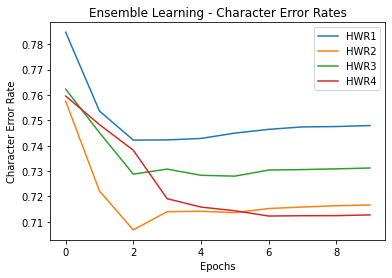

HWR1: [0.7846743025493025, 0.753638456913457, 0.7421994366744367, 0.7422723757723759, 0.7428511021386021, 0.7449473221223222, 0.7464364931364931, 0.747392132867133, 0.7475434015059014, 0.7479359501609502, 0.7481538674288675, 0.7480897139897138, 0.7482046670921672, 0.7482255004255004, 0.7482255004255005, 0.7482588337588338, 0.748258833758834, 0.7483159766159767, 0.7483159766159767, 0.7483344951344951, 0.7482511618011618, 0.748271995134495, 0.7482905136530137, 0.7483886618011619, 0.7484905136530136, 0.7485389985014984]
HWR2: [0.7575273492710993, 0.7221685552873052, 0.706835128066378, 0.7140125161875162, 0.7141816239316238, 0.7136190772190771, 0.7152610542235542, 0.7158434676434678, 0.716360113960114, 0.7166535182410184, 0.716605833055833, 0.7165426716801716, 0.7164861901986902, 0.7164861901986902, 0.7165278568653568, 0.7165278568653568, 0.7165278568653568, 0.7165516663891666, 0.7166084845709846, 0.7165251512376514, 0.7165251512376511, 0.7165251512376511, 0.7165668179043178, 0.71663626234

In [79]:
plt.title('Ensemble Learning - Character Error Rates')
plt.xlabel('Epochs')
plt.ylabel('Character Error Rate')
plt.plot(cers[0][:10], label='HWR1')
plt.plot(cers[1][:10], label='HWR2')
plt.plot(cers[2][:10], label='HWR3')
plt.plot(cers[3][:10], label='HWR4')
plt.legend()
plt.show()
print('HWR1:', cers[0])
print('HWR2:', cers[1])
print('HWR3:', cers[2])
print('HWR4:', cers[3])

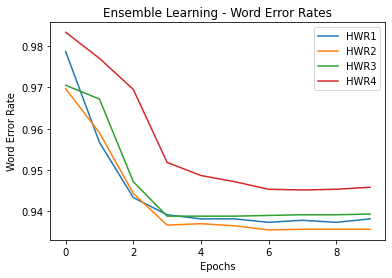

HWR1: [0.9786666666666667, 0.9566666666666668, 0.9433333333333334, 0.9391666666666666, 0.9381666666666665, 0.9381666666666667, 0.9373333333333332, 0.9378333333333333, 0.9373333333333334, 0.9381666666666665, 0.9381666666666667, 0.9381666666666665, 0.9381666666666667, 0.9381666666666667, 0.9381666666666667, 0.9381666666666665, 0.9381666666666668, 0.9381666666666667, 0.9381666666666665, 0.9381666666666665, 0.9380000000000001, 0.9380000000000001, 0.9380000000000001, 0.9381666666666668, 0.9381666666666665, 0.9381666666666665]
HWR2: [0.9696666666666666, 0.9590000000000002, 0.9443333333333334, 0.9366666666666666, 0.9369999999999999, 0.9364999999999998, 0.9354999999999999, 0.9356666666666666, 0.9356666666666666, 0.9356666666666665, 0.9356666666666666, 0.9356666666666668, 0.9356666666666666, 0.9356666666666665, 0.9356666666666665, 0.9356666666666668, 0.9356666666666666, 0.9356666666666665, 0.9356666666666665, 0.9354999999999999, 0.9354999999999998, 0.9354999999999999, 0.9354999999999999, 0.9355

In [78]:
plt.title('Ensemble Learning - Word Error Rates')
plt.xlabel('Epochs')
plt.ylabel('Word Error Rate')
plt.plot(wers[0][:10], label='HWR1')
plt.plot(wers[1][:10], label='HWR2')
plt.plot(wers[2][:10], label='HWR3')
plt.plot(wers[3][:10], label='HWR4')
plt.legend()
plt.show()
print('HWR1:', wers[0])
print('HWR2:', wers[1])
print('HWR3:', wers[2])
print('HWR4:', wers[3])

Length:  30000
Transcription:  de


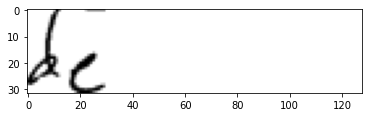

In [0]:
rimes = RimesDataset(total_imgs=30000)
index = 10226

print('Length: ', len(rimes))
print('Transcription: ', rimes[index][1])
plt.imshow(rimes[index][0].squeeze(), cmap='gray')